In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit
from scipy.stats import entropy

from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..'))

sys.path.append(project_root)

print("ROOT:", project_root)
from Early_predict_UQ.data.make_dataset import make_data
from Early_predict_UQ.data.plots import plot_accuracy_over_time_and_epochs, plot_confidence_over_time_and_epochs, plot_entropy_over_time_and_epochs, plot_probabilities_over_time_and_epochs

#from feauterimport plot_entropy_over_time

#add for when only 1 epoch

def predict_expanding(initial_window_length, w_start, w_step, y_test, epochs_data, test_idx, probs_this_window, chosen_epoch = None):
    score_this_window = []
    #preds_this_window = []
    entropy_this_window = []
    confidence_this_window = []
    for n, window_start in enumerate(w_start):
        window_length = initial_window_length + n * w_step
        X_test  = csp.transform(epochs_data[test_idx][:, :, window_start:(window_start + window_length)])
        #print("X_test  shape:\n",X_test.shape)
        if chosen_epoch != None:
            X_test = X_test [chosen_epoch] #Chooosing a specific epoch in the test set 
        #Accuracy
        score = lda.score(X_test, y_test)
        score_this_window.append(score)
        
        probabilities = lda.predict_proba(X_test)
        
        if len(probs_this_window) == 0:
            probs_this_window = probabilities
        else:
            probs_this_window = np.vstack((probs_this_window, probabilities))

       # print("Prediction for this time window: ", prediction)
        #print("prob shape: ", probabilities.shape)
        #print("probabilities: \n", probabilities)

        #predictive entropy - H_pred(p) 
        entropy_score = entropy(probabilities, axis = 1) #- see if entropy is better than probabilites
        entropy_this_window.append(entropy_score)

        '''
        Confidence - as seen in: 
        Uncertainty Quantification in Machine Learning for Biosignal Applications - A Review, page 13.
        1 - H_pred(p) can be used as a confidence measure. Normalizing seems useful - 1 / (1- entropy-score)
        '''
        #confidence
        confidence = 1 - entropy_score
        confidence_this_window.append(confidence)

    return score_this_window, probs_this_window, entropy_this_window, confidence_this_window


#def predict_sliding():
    
threshold = 0.7
subject_list = [1]

# Preprocessed epochs
epochs, labels = make_data(subject_list)


# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross validation 
## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(2, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

# Classify the signal using a sliding window or expanding window
w_length = int(sfreq * 0.5)  # Window length/initial window length
w_step = int(sfreq * 0.1)  # window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) #
print("w start shape: ", w_start.shape)

class_names = {
        1: "Left hand",
        2: "Right hand",
        3: "Both feet",
        4: "Tongue"
}

probabilities_windows = []
scores_windows = []  
confidence_windows = []
entropy_windows = []
traversal_type = 'expanding'
c= 0
# Running classification across the signal
for train_idx, test_idx in cv_split:
    c += 1
    y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data
    
    # Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # Fit the classifier on the training data
    lda.fit(X_train, y_train)
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

    # Test the classifier on the windows. This is where we run over the signal
    probs_this_window = []
    #chosen_epoch = 80
    if traversal_type == 'sliding':
        traversal_type = 'sliding'
        #predict_sliding()
    else:
        #traversal_type == 'expanding'
        score_this_window, probs_this_window, entropy_this_window, confidence_this_window = predict_expanding(
            w_length, 
            w_start,
            w_step,
            y_test,
            epochs_data,
            test_idx,
            probs_this_window,
            chosen_epoch = None
        )

    if c == 1:
        print(probs_this_window)
        probabilities_windows = np.mean(probs_this_window, 0)
        print(probs_this_window.shape)
    else:
        probabilities_windows = np.vstack((probabilities_windows,  np.mean(probs_this_window)))

    scores_windows.append(score_this_window)
    confidence_windows.append(confidence_this_window)
    entropy_windows.append(entropy_this_window)


Choosing from all possible events


ROOT: c:\Users\Eier\Documents\UNI\Bachelor_thesis\UQ_Early_prediction_MI_BCI
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequen

c:\Users\Eier\miniconda3\envs\mne\Lib\site-packages\moabb\paradigms\base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3041 task

w start shape:  (36,)
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 1

accuracy_all shape:  2
confindence_all shape:  2
probs:  [[2.27484369e-01 4.78495557e-01 2.90366161e-01 3.65391332e-03]
 [5.53373670e-04 5.84723043e-04 2.77623541e-01 7.21238363e-01]
 [9.25157351e-01 5.95069238e-02 1.51084287e-02 2.27296207e-04]
 ...
 [9.39030329e-01 2.79986092e-03 1.91998867e-02 3.89699237e-02]
 [9.97233897e-01 3.35010746e-05 2.00658167e-03 7.26020457e-04]
 [3.32319081e-01 5.18965482e-01 1.47008104e-01 1.70733249e-03]]


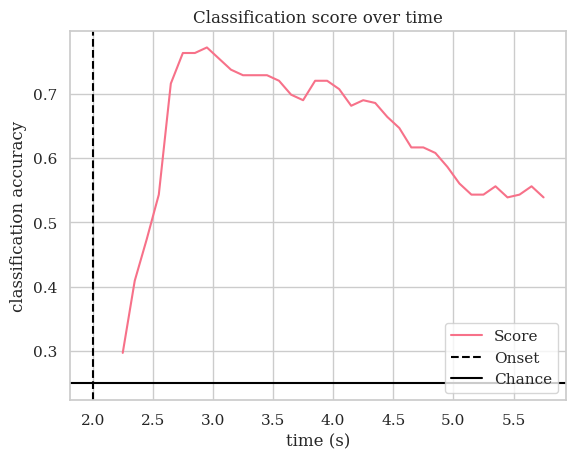

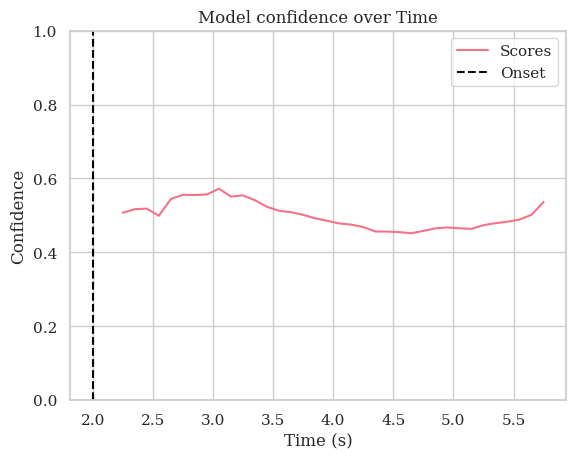

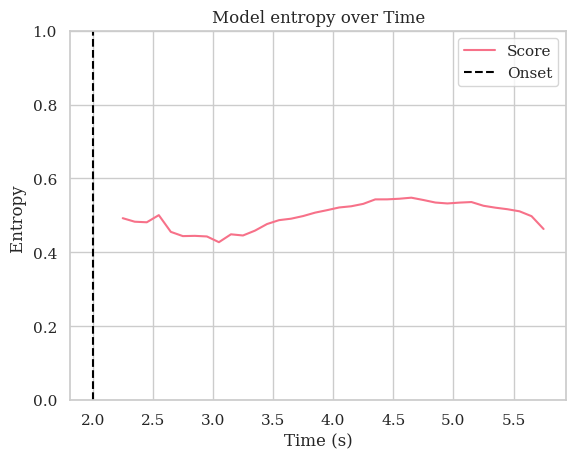

ValueError: x and y must have same first dimension, but have shapes (36,) and (8352,)

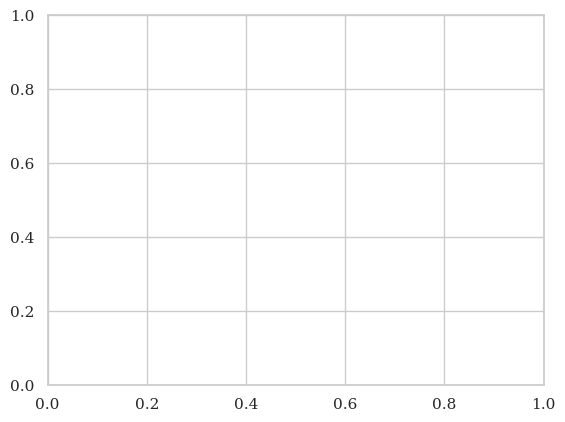

In [ ]:
# Plot the scores over time
print("accuracy_all shape: ", len(scores_windows))
print("confindence_all shape: ", len(confidence_windows))
print("probs: ", probabilities_windows)
plot_accuracy_over_time_and_epochs(w_times, scores_windows, class_balance)
plot_confidence_over_time_and_epochs(w_times, np.mean(confidence_windows, 0).T, threshold)
plot_entropy_over_time_and_epochs(w_times, np.mean(entropy_windows, 0).T)
plot_probabilities_over_time_and_epochs(w_times, probabilities_windows, threshold, class_names)

